## Redes Neurais Artificiais 2022.2

#### Atividade Avaliativa 2.3

- **Disciplina**: Redes Neurais Artificiais 2022.2

- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)

- **Github**: https://github.com/jo-alves01/rna-aa3


Sobre a base de dados:

O dataset "Maternal Health Risk Data Set" contém informações relacionadas à saúde materna e risco de complicações durante a gestação. As variáveis do conjunto de dados incluem informações como idade, além de dados clínicos, como pressão arterial e níveis de glicose no sangue.

#### Equipe:

Carlos Gabriel da Silva Machado - 1815080079

Davi Rodrigues de França - 1915080053

Gabriella Rabelo Monteiro - 1915080011

Josué Costa dos Santos Alves - 1715080615

Victor Hugo Santos de Lima - 1915080025

## Bibliotecas

In [104]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

## Funções úteis

In [105]:
def plot_hist_box(data, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[0].set_title(f"Histograma de {col}")
    ax[1].set_title(f"Boxplot de {col}")

    plt.show()

## Leitura do Dataset

In [106]:
mhr_dataset_base = pd.read_csv("./maternal_health_risk_data_set.csv")

In [107]:
mhr_dataset_base.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [108]:
mhr_dataset_base.rename(columns={"BS": "BloodSugar"}, inplace=True)
mhr_dataset_base.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## Apresentação do dataset

O dataset possui 7 atribuitos no total, sendo eles:


*   **Age**: Idade da mulher;
*   **SystolicBP**: Valor superior da pressão arterial em mmHg;
*   **DiastolicBP**: Valor mais baixo da pressão arterial em mmHg;
*   **BS**: Os níveis de glicose no sangue, em termos de uma concentração molar (mmol/L);
*   **BodyTemp**: Temperatura corporal da mulher (em °F);
*   **HeartRate**: Uma frequência cardíaca normal em repouso em batimentos por minuto;
*   **Risk Level**: Nível de intensidade de risco previsto durante a gravidez.

Os tipos dos dados são: Age: inteiro, SystolicBP: inteiro, DiastolicBP: inteiro, BS: float, BodyTemp: float, HeartRate: inteiro, RiskLevel: objeto.

As informações podem ser observadas abaixo:

In [109]:
mhr_dataset_base.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BloodSugar     float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [110]:
mhr_dataset_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BloodSugar   1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Verificação da quantidade de exemplos e atributos preditores

In [111]:
columns = len(mhr_dataset_base.axes[1])
rows = len(mhr_dataset_base.axes[0])

print("Quantidade de exemplo:",rows)
print("Quantidade de atributos preditores:",columns-1,)
print("Atributos preditores:",mhr_dataset_base.axes[1][0], mhr_dataset_base.axes[1][1], mhr_dataset_base.axes[1][2], mhr_dataset_base.axes[1][3], mhr_dataset_base.axes[1][4], mhr_dataset_base.axes[1][5])
print("Quantidade de atributos alvo:", columns-(columns-1))
print("Atributo alvo:",mhr_dataset_base.axes[1][6])

Quantidade de exemplo: 1014
Quantidade de atributos preditores: 6
Atributos preditores: Age SystolicBP DiastolicBP BloodSugar BodyTemp HeartRate
Quantidade de atributos alvo: 1
Atributo alvo: RiskLevel


Checando se existem dados faltantes no dataset:

In [112]:
mhr_dataset_base.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BloodSugar     0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

Verificando quantos exemplos existem para cada classe do atributo alvo:

In [113]:
mhr_dataset_base['RiskLevel'].value_counts()

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64

Abaixo pode-se observar alguns dados gerais sobre o dataset:

In [114]:
mhr_dataset_base.describe()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Abaixo é possível observar a distribuição dos dados dentro do dataset

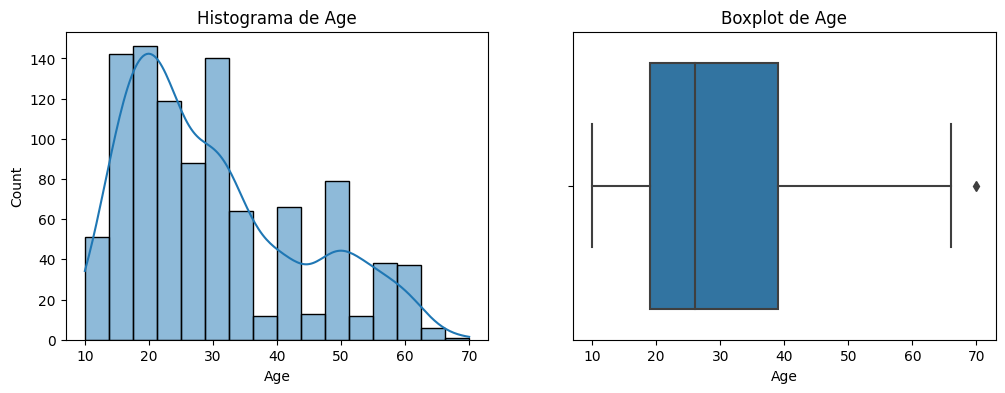

In [115]:
plot_hist_box(mhr_dataset_base, 'Age')

É possível observar que o atributo Age possui sua mediana em torno de 26 anos e que existem muitos exemplos entre os valores de 20 até 35 anos, enquanto valores maiores e menores que esse intervalo possuem poucos exemplos.

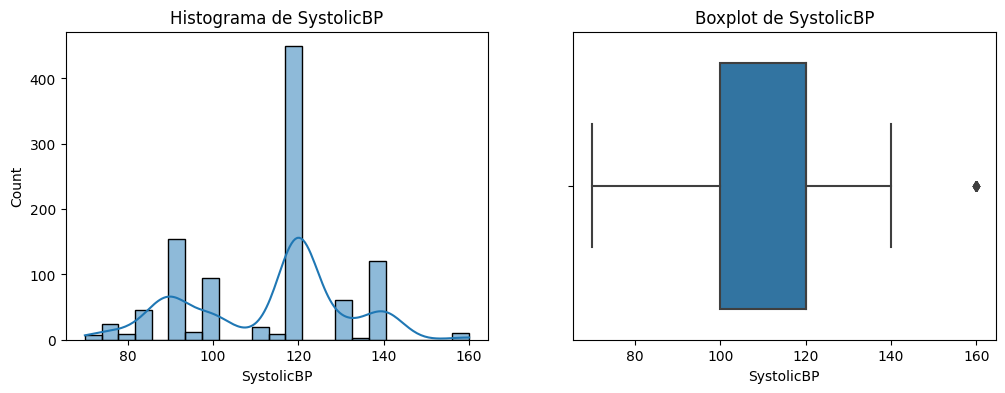

In [116]:
plot_hist_box(mhr_dataset_base, 'SystolicBP')

Ao examinar os gráficos acima, pode-se afirmar que a mediana do atributo SystolicBP é em torno de 120, com uma grande quantidade de exemplos na faixa de 100 até 120, além de verificar um pequeno grupo de exemplos entre os valores de 80 até 100, e entre 130 até 140. É também visível um *outlier* no valor 160.

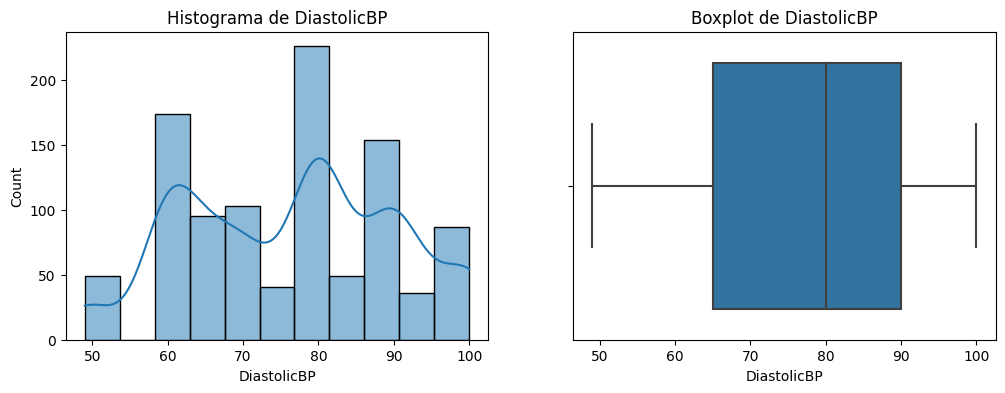

In [117]:
plot_hist_box(mhr_dataset_base, 'DiastolicBP')

O atributo DiastolicBP possui sua mediana em 80, com exemplos relativamente bem distribuídos, principalmente na faixa entre 65 e 90.

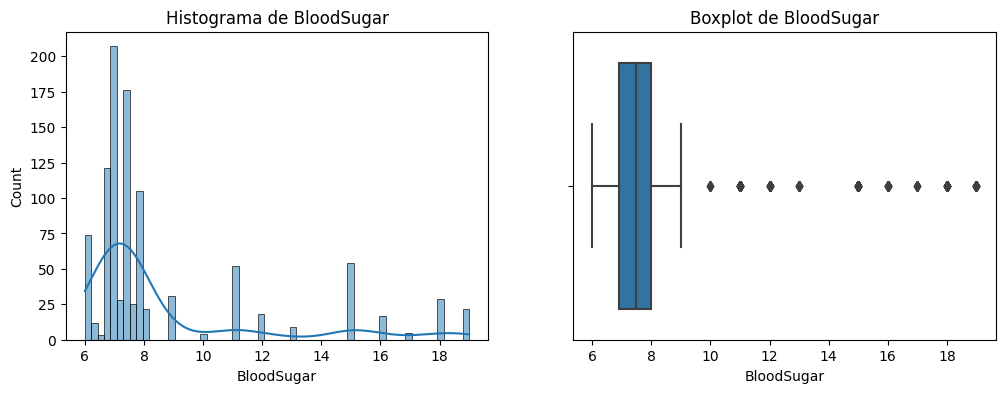

In [118]:
plot_hist_box(mhr_dataset_base, 'BloodSugar')

Diferente do atributo DiastolicBP, o atributo BloodSugar possui exemplos dispersos, com sua grande maioria entre os valores de 7 e 8, sua mediana é em torno de 7,5. É bastante visível os diversos *outliers* existentes neste atributo.

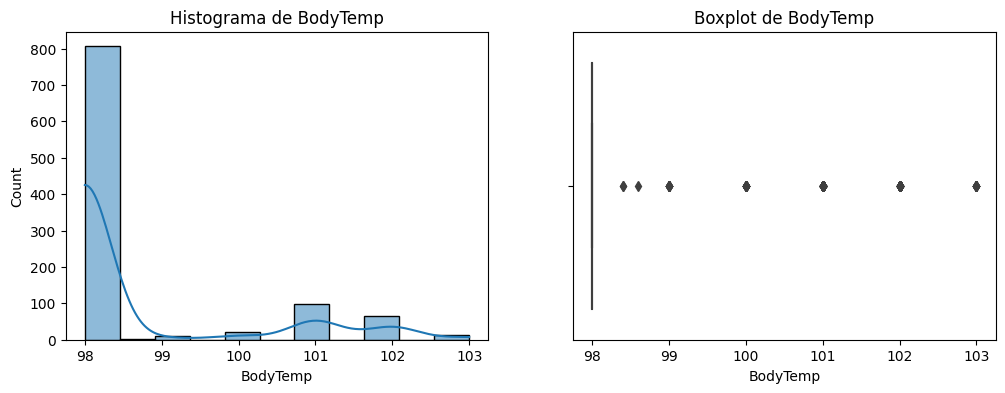

In [119]:
plot_hist_box(mhr_dataset_base, 'BodyTemp')

É notável a dispariedade dos valores dos exemplos do atributo BodyTemp, com sua mediana e a maioria dos exemplos com valor 98, e os outro valores sendo considerados quase *outliers*, apesar de estarem próximo do valor 98.

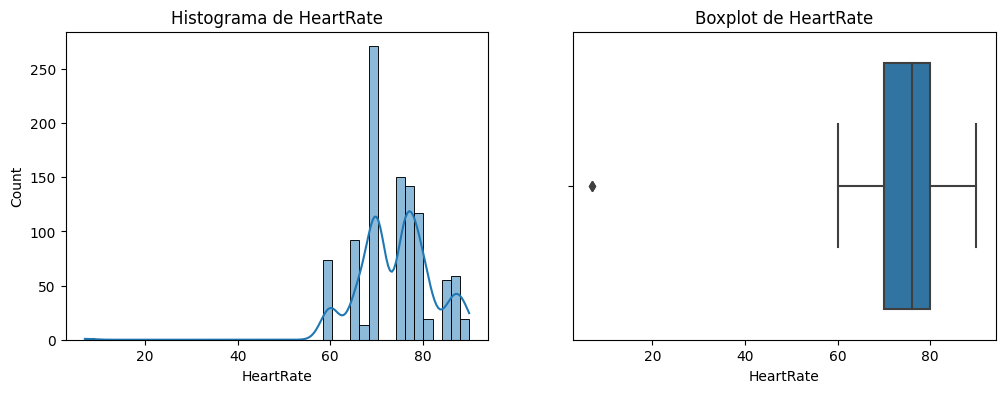

In [120]:
plot_hist_box(mhr_dataset_base, 'HeartRate')

Por último, o atributo HeartRate possui a maioria dos seus exemplos entre 70 e 80, e sua mediana é de aproximadamente 75. É possível obervar a existência de um *outlier* próximo do valor 10.

## Preparação dos dados

### Categorização dos dados

## Separando a base de dados em atributos preditores e alvos

In [121]:
X = mhr_dataset_base.drop(columns=["RiskLevel"],axis=1)
y = mhr_dataset_base["RiskLevel"]

## Realizando a normalização dos dados

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train_norm = (X_train - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_test_norm = (X_test - X_test.min(axis=0))/(X_test.max(axis=0) - X_test.min(axis=0))

In [123]:
mlp = MLPClassifier( activation='relu', solver='adam', learning_rate_init=0.001, max_iter=300,verbose=False, random_state=42)

In [124]:
pipe = Pipeline([('mlp', mlp)])
param_grid = {
    'mlp__hidden_layer_sizes': [9,8],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__batch_size': [16],
    'mlp__beta_1': [0.999, 0.9, 0.8],
    'mlp__beta_2': [0.999, 0.95, 0.9],
    'mlp__n_iter_no_change': [25],
}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='recall_micro')

In [125]:
grid.fit(X_train_norm,y_train)

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the opti

GridSearchCV(estimator=Pipeline(steps=[('mlp',
                                        MLPClassifier(max_iter=300,
                                                      random_state=42))]),
             param_grid={'mlp__activation': ['relu'], 'mlp__batch_size': [16],
                         'mlp__beta_1': [0.999, 0.9, 0.8],
                         'mlp__beta_2': [0.999, 0.95, 0.9],
                         'mlp__hidden_layer_sizes': [9, 8],
                         'mlp__n_iter_no_change': [25],
                         'mlp__solver': ['adam']},
             scoring='recall_micro')

In [126]:
top_3 = pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score", ignore_index=True)[:3]
top_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__batch_size,param_mlp__beta_1,param_mlp__beta_2,param_mlp__hidden_layer_sizes,param_mlp__n_iter_no_change,param_mlp__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.189616,0.080738,0.003076,0.000218,relu,16,0.8,0.95,8,25,adam,"{'mlp__activation': 'relu', 'mlp__batch_size':...",0.683099,0.669014,0.683099,0.676056,0.666667,0.675587,0.006868,1
1,3.621057,0.424751,0.003420,0.000329,relu,16,0.9,0.95,8,25,adam,"{'mlp__activation': 'relu', 'mlp__batch_size':...",0.676056,0.661972,0.676056,0.676056,0.673759,0.672780,0.005477,2
2,4.183105,0.537366,0.004462,0.001451,relu,16,0.8,0.9,8,25,adam,"{'mlp__activation': 'relu', 'mlp__batch_size':...",0.683099,0.661972,0.676056,0.676056,0.666667,0.672770,0.007512,3


In [127]:
mlp1 = MLPClassifier(activation=top_3.param_mlp__activation[0], solver=top_3.param_mlp__solver[0], hidden_layer_sizes=top_3.param_mlp__hidden_layer_sizes[0], learning_rate_init=0.001, beta_1=top_3.param_mlp__beta_1[0], beta_2=top_3.param_mlp__beta_2[0], max_iter=600, n_iter_no_change=top_3.param_mlp__n_iter_no_change[0], verbose=True, random_state=42)
h1 = mlp1.fit(X_train_norm, y_train)

mlp2 = MLPClassifier(activation=top_3.param_mlp__activation[1], solver=top_3.param_mlp__solver[1], hidden_layer_sizes=top_3.param_mlp__hidden_layer_sizes[1], learning_rate_init=0.001, beta_1=top_3.param_mlp__beta_1[1], beta_2=top_3.param_mlp__beta_2[1], max_iter=600, n_iter_no_change=top_3.param_mlp__n_iter_no_change[1], verbose=True, random_state=42)
h2 = mlp2.fit(X_train_norm, y_train)

mlp3 = MLPClassifier(activation=top_3.param_mlp__activation[2], solver=top_3.param_mlp__solver[2], hidden_layer_sizes=top_3.param_mlp__hidden_layer_sizes[2], learning_rate_init=0.001, beta_1=top_3.param_mlp__beta_1[2], beta_2=top_3.param_mlp__beta_2[2], max_iter=600, n_iter_no_change=top_3.param_mlp__n_iter_no_change[2], verbose=True, random_state=42)
h3 = mlp3.fit(X_train_norm, y_train)

Iteration 1, loss = 1.13273870
Iteration 2, loss = 1.12548800
Iteration 3, loss = 1.11869120
Iteration 4, loss = 1.11245562
Iteration 5, loss = 1.10735888
Iteration 6, loss = 1.10220578
Iteration 7, loss = 1.09770051
Iteration 8, loss = 1.09325263
Iteration 9, loss = 1.08956314
Iteration 10, loss = 1.08569287
Iteration 11, loss = 1.08211618
Iteration 12, loss = 1.07856797
Iteration 13, loss = 1.07522963
Iteration 14, loss = 1.07203614
Iteration 15, loss = 1.06905354
Iteration 16, loss = 1.06642234
Iteration 17, loss = 1.06340098
Iteration 18, loss = 1.06075517
Iteration 19, loss = 1.05793343
Iteration 20, loss = 1.05549666
Iteration 21, loss = 1.05287153
Iteration 22, loss = 1.05035012
Iteration 23, loss = 1.04786725
Iteration 24, loss = 1.04529021
Iteration 25, loss = 1.04277950
Iteration 26, loss = 1.04036145
Iteration 27, loss = 1.03786690
Iteration 28, loss = 1.03546685
Iteration 29, loss = 1.03300089
Iteration 30, loss = 1.03049833
Iteration 31, loss = 1.02819512
Iteration 32, los

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 79, loss = 0.92372327
Iteration 80, loss = 0.92198712
Iteration 81, loss = 0.92019496
Iteration 82, loss = 0.91847458
Iteration 83, loss = 0.91671296
Iteration 84, loss = 0.91489757
Iteration 85, loss = 0.91322272
Iteration 86, loss = 0.91143308
Iteration 87, loss = 0.90959703
Iteration 88, loss = 0.90783169
Iteration 89, loss = 0.90605495
Iteration 90, loss = 0.90438034
Iteration 91, loss = 0.90265539
Iteration 92, loss = 0.90092246
Iteration 93, loss = 0.89928501
Iteration 94, loss = 0.89766486
Iteration 95, loss = 0.89604502
Iteration 96, loss = 0.89435190
Iteration 97, loss = 0.89273210
Iteration 98, loss = 0.89108922
Iteration 99, loss = 0.88958967
Iteration 100, loss = 0.88797829
Iteration 101, loss = 0.88644463
Iteration 102, loss = 0.88488513
Iteration 103, loss = 0.88343430
Iteration 104, loss = 0.88186146
Iteration 105, loss = 0.88033653
Iteration 106, loss = 0.87898223
Iteration 107, loss = 0.87743952
Iteration 108, loss = 0.87611188
Iteration 109, loss = 0.8746499

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 74, loss = 0.93250691
Iteration 75, loss = 0.93055408
Iteration 76, loss = 0.92866682
Iteration 77, loss = 0.92692386
Iteration 78, loss = 0.92502215
Iteration 79, loss = 0.92321410
Iteration 80, loss = 0.92153579
Iteration 81, loss = 0.91979563
Iteration 82, loss = 0.91803334
Iteration 83, loss = 0.91625720
Iteration 84, loss = 0.91440602
Iteration 85, loss = 0.91269783
Iteration 86, loss = 0.91085796
Iteration 87, loss = 0.90897856
Iteration 88, loss = 0.90715126
Iteration 89, loss = 0.90530125
Iteration 90, loss = 0.90360400
Iteration 91, loss = 0.90190154
Iteration 92, loss = 0.90017881
Iteration 93, loss = 0.89858864
Iteration 94, loss = 0.89693795
Iteration 95, loss = 0.89529186
Iteration 96, loss = 0.89354009
Iteration 97, loss = 0.89189751
Iteration 98, loss = 0.89024845
Iteration 99, loss = 0.88877353
Iteration 100, loss = 0.88713313
Iteration 101, loss = 0.88561984
Iteration 102, loss = 0.88404277
Iteration 103, loss = 0.88255301
Iteration 104, loss = 0.88096963
Ite

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


In [128]:
test_predictions1 = h1.predict(X_test_norm)
test_predictions2 = h2.predict(X_test_norm)
test_predictions3 = h3.predict(X_test_norm)
print('Revocação para MLP1: ',recall_score(y_test, test_predictions1,average='weighted'))
print('Revocação para MLP2: ',recall_score(y_test, test_predictions2,average='weighted'))
print('Revocação para MLP3: ',recall_score(y_test, test_predictions3,average='weighted'))

Revocação para MLP1:  0.6524590163934426
Revocação para MLP2:  0.6524590163934426
Revocação para MLP3:  0.6524590163934426


### K-FOLD

In [129]:
kfold = KFold(n_splits=3)
result1 = cross_val_score(mlp1, X_test_norm, y_test, cv = kfold, scoring='recall_micro')
result2 = cross_val_score(mlp2, X_test_norm, y_test, cv = kfold, scoring='recall_micro')
result3 = cross_val_score(mlp3, X_test_norm, y_test, cv = kfold, scoring='recall_micro')

Iteration 1, loss = 1.11641293
Iteration 2, loss = 1.11447704
Iteration 3, loss = 1.11333523
Iteration 4, loss = 1.11161119
Iteration 5, loss = 1.10987219
Iteration 6, loss = 1.10836643
Iteration 7, loss = 1.10675485
Iteration 8, loss = 1.10551812
Iteration 9, loss = 1.10483684
Iteration 10, loss = 1.10436804
Iteration 11, loss = 1.10414808
Iteration 12, loss = 1.10383116
Iteration 13, loss = 1.10316582
Iteration 14, loss = 1.10194739
Iteration 15, loss = 1.10030370
Iteration 16, loss = 1.09881391
Iteration 17, loss = 1.09752302
Iteration 18, loss = 1.09617634
Iteration 19, loss = 1.09507992
Iteration 20, loss = 1.09434179
Iteration 21, loss = 1.09390879
Iteration 22, loss = 1.09303946
Iteration 23, loss = 1.09166154
Iteration 24, loss = 1.09018231
Iteration 25, loss = 1.08870124
Iteration 26, loss = 1.08741691
Iteration 27, loss = 1.08644285
Iteration 28, loss = 1.08546117
Iteration 29, loss = 1.08481282
Iteration 30, loss = 1.08447653
Iteration 31, loss = 1.08412866
Iteration 32, los

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 181, loss = 0.99017996
Iteration 182, loss = 0.98962343
Iteration 183, loss = 0.98909781
Iteration 184, loss = 0.98854085
Iteration 185, loss = 0.98797180
Iteration 186, loss = 0.98733573
Iteration 187, loss = 0.98676030
Iteration 188, loss = 0.98621155
Iteration 189, loss = 0.98561432
Iteration 190, loss = 0.98500057
Iteration 191, loss = 0.98421805
Iteration 192, loss = 0.98339371
Iteration 193, loss = 0.98269644
Iteration 194, loss = 0.98223760
Iteration 195, loss = 0.98176522
Iteration 196, loss = 0.98138105
Iteration 197, loss = 0.98107426
Iteration 198, loss = 0.98068713
Iteration 199, loss = 0.98015171
Iteration 200, loss = 0.97949152
Iteration 201, loss = 0.97881066
Iteration 202, loss = 0.97804844
Iteration 203, loss = 0.97730312
Iteration 204, loss = 0.97660866
Iteration 205, loss = 0.97592311
Iteration 206, loss = 0.97517243
Iteration 207, loss = 0.97444714
Iteration 208, loss = 0.97368802
Iteration 209, loss = 0.97298912
Iteration 210, loss = 0.97247081
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 176, loss = 0.98147274
Iteration 177, loss = 0.98088706
Iteration 178, loss = 0.98039319
Iteration 179, loss = 0.97987417
Iteration 180, loss = 0.97938688
Iteration 181, loss = 0.97873771
Iteration 182, loss = 0.97806754
Iteration 183, loss = 0.97751281
Iteration 184, loss = 0.97689455
Iteration 185, loss = 0.97622618
Iteration 186, loss = 0.97544394
Iteration 187, loss = 0.97460672
Iteration 188, loss = 0.97390911
Iteration 189, loss = 0.97331108
Iteration 190, loss = 0.97282684
Iteration 191, loss = 0.97220134
Iteration 192, loss = 0.97169303
Iteration 193, loss = 0.97114555
Iteration 194, loss = 0.97054886
Iteration 195, loss = 0.96989565
Iteration 196, loss = 0.96921570
Iteration 197, loss = 0.96854090
Iteration 198, loss = 0.96795566
Iteration 199, loss = 0.96738170
Iteration 200, loss = 0.96684363
Iteration 201, loss = 0.96630212
Iteration 202, loss = 0.96562427
Iteration 203, loss = 0.96497257
Iteration 204, loss = 0.96436639
Iteration 205, loss = 0.96375577
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 187, loss = 0.99310590
Iteration 188, loss = 0.99257014
Iteration 189, loss = 0.99205313
Iteration 190, loss = 0.99156912
Iteration 191, loss = 0.99106320
Iteration 192, loss = 0.99052533
Iteration 193, loss = 0.99004722
Iteration 194, loss = 0.98956904
Iteration 195, loss = 0.98903756
Iteration 196, loss = 0.98855718
Iteration 197, loss = 0.98811450
Iteration 198, loss = 0.98755730
Iteration 199, loss = 0.98697004
Iteration 200, loss = 0.98639313
Iteration 201, loss = 0.98578715
Iteration 202, loss = 0.98516020
Iteration 203, loss = 0.98450427
Iteration 204, loss = 0.98384764
Iteration 205, loss = 0.98320135
Iteration 206, loss = 0.98256374
Iteration 207, loss = 0.98191020
Iteration 208, loss = 0.98129530
Iteration 209, loss = 0.98077190
Iteration 210, loss = 0.98035743
Iteration 211, loss = 0.97990620
Iteration 212, loss = 0.97948737
Iteration 213, loss = 0.97915376
Iteration 214, loss = 0.97883585
Iteration 215, loss = 0.97845078
Iteration 216, loss = 0.97807622
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 197, loss = 0.98055137
Iteration 198, loss = 0.98010960
Iteration 199, loss = 0.97959117
Iteration 200, loss = 0.97901700
Iteration 201, loss = 0.97840886
Iteration 202, loss = 0.97774014
Iteration 203, loss = 0.97703923
Iteration 204, loss = 0.97635162
Iteration 205, loss = 0.97565199
Iteration 206, loss = 0.97491359
Iteration 207, loss = 0.97421140
Iteration 208, loss = 0.97347530
Iteration 209, loss = 0.97281142
Iteration 210, loss = 0.97227737
Iteration 211, loss = 0.97175963
Iteration 212, loss = 0.97134429
Iteration 213, loss = 0.97107203
Iteration 214, loss = 0.97072924
Iteration 215, loss = 0.97027672
Iteration 216, loss = 0.96982868
Iteration 217, loss = 0.96941138
Iteration 218, loss = 0.96906021
Iteration 219, loss = 0.96861186
Iteration 220, loss = 0.96809804
Iteration 221, loss = 0.96756477
Iteration 222, loss = 0.96703822
Iteration 223, loss = 0.96645953
Iteration 224, loss = 0.96590982
Iteration 225, loss = 0.96533321
Iteration 226, loss = 0.96484368
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 216, loss = 0.95747379
Iteration 217, loss = 0.95694390
Iteration 218, loss = 0.95634611
Iteration 219, loss = 0.95572909
Iteration 220, loss = 0.95514778
Iteration 221, loss = 0.95452804
Iteration 222, loss = 0.95390694
Iteration 223, loss = 0.95329255
Iteration 224, loss = 0.95270756
Iteration 225, loss = 0.95217125
Iteration 226, loss = 0.95170543
Iteration 227, loss = 0.95116006
Iteration 228, loss = 0.95061295
Iteration 229, loss = 0.95006687
Iteration 230, loss = 0.94952909
Iteration 231, loss = 0.94893045
Iteration 232, loss = 0.94829768
Iteration 233, loss = 0.94767515
Iteration 234, loss = 0.94710768
Iteration 235, loss = 0.94654635
Iteration 236, loss = 0.94604119
Iteration 237, loss = 0.94557304
Iteration 238, loss = 0.94505455
Iteration 239, loss = 0.94450044
Iteration 240, loss = 0.94391291
Iteration 241, loss = 0.94331867
Iteration 242, loss = 0.94271002
Iteration 243, loss = 0.94215999
Iteration 244, loss = 0.94157853
Iteration 245, loss = 0.94107349
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 220, loss = 0.97723672
Iteration 221, loss = 0.97680303
Iteration 222, loss = 0.97630672
Iteration 223, loss = 0.97572668
Iteration 224, loss = 0.97517898
Iteration 225, loss = 0.97468606
Iteration 226, loss = 0.97412231
Iteration 227, loss = 0.97359569
Iteration 228, loss = 0.97307852
Iteration 229, loss = 0.97240701
Iteration 230, loss = 0.97169172
Iteration 231, loss = 0.97101548
Iteration 232, loss = 0.97030704
Iteration 233, loss = 0.96955994
Iteration 234, loss = 0.96884241
Iteration 235, loss = 0.96815608
Iteration 236, loss = 0.96746510
Iteration 237, loss = 0.96674376
Iteration 238, loss = 0.96597717
Iteration 239, loss = 0.96526177
Iteration 240, loss = 0.96456767
Iteration 241, loss = 0.96389928
Iteration 242, loss = 0.96332886
Iteration 243, loss = 0.96274802
Iteration 244, loss = 0.96218650
Iteration 245, loss = 0.96170368
Iteration 246, loss = 0.96124617
Iteration 247, loss = 0.96073324
Iteration 248, loss = 0.96014392
Iteration 249, loss = 0.95956600
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 186, loss = 0.98733578
Iteration 187, loss = 0.98673056
Iteration 188, loss = 0.98617191
Iteration 189, loss = 0.98555415
Iteration 190, loss = 0.98490858
Iteration 191, loss = 0.98412048
Iteration 192, loss = 0.98329825
Iteration 193, loss = 0.98260295
Iteration 194, loss = 0.98216143
Iteration 195, loss = 0.98169505
Iteration 196, loss = 0.98129061
Iteration 197, loss = 0.98095911
Iteration 198, loss = 0.98054108
Iteration 199, loss = 0.97995928
Iteration 200, loss = 0.97923550
Iteration 201, loss = 0.97850616
Iteration 202, loss = 0.97771311
Iteration 203, loss = 0.97694042
Iteration 204, loss = 0.97620302
Iteration 205, loss = 0.97547593
Iteration 206, loss = 0.97468552
Iteration 207, loss = 0.97396478
Iteration 208, loss = 0.97321866
Iteration 209, loss = 0.97255172
Iteration 210, loss = 0.97208554
Iteration 211, loss = 0.97163844
Iteration 212, loss = 0.97136729
Iteration 213, loss = 0.97124934
Iteration 214, loss = 0.97097189
Iteration 215, loss = 0.97049523
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 176, loss = 0.98180570
Iteration 177, loss = 0.98123551
Iteration 178, loss = 0.98075461
Iteration 179, loss = 0.98023510
Iteration 180, loss = 0.97974252
Iteration 181, loss = 0.97908475
Iteration 182, loss = 0.97840061
Iteration 183, loss = 0.97781959
Iteration 184, loss = 0.97716160
Iteration 185, loss = 0.97645352
Iteration 186, loss = 0.97563471
Iteration 187, loss = 0.97478674
Iteration 188, loss = 0.97409509
Iteration 189, loss = 0.97350368
Iteration 190, loss = 0.97302045
Iteration 191, loss = 0.97240304
Iteration 192, loss = 0.97192156
Iteration 193, loss = 0.97140710
Iteration 194, loss = 0.97083159
Iteration 195, loss = 0.97019716
Iteration 196, loss = 0.96952505
Iteration 197, loss = 0.96884247
Iteration 198, loss = 0.96823835
Iteration 199, loss = 0.96765739
Iteration 200, loss = 0.96712506
Iteration 201, loss = 0.96659179
Iteration 202, loss = 0.96593388
Iteration 203, loss = 0.96530456
Iteration 204, loss = 0.96470449
Iteration 205, loss = 0.96409301
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


In [135]:
print(f"Resultado para mlp1: {result1}")
print(f"Resultado para mlp2: {result2}")
print(f"Resultado para mlp3: {result3}")

Resultado para mlp1: [0.67647059 0.57843137 0.55445545]
Resultado para mlp2: [0.64705882 0.57843137 0.56435644]
Resultado para mlp3: [0.67647059 0.57843137 0.56435644]
